Importing necessary parameters

In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt

In [3]:
img_r = cv2.imread("./000000.png", cv2.IMREAD_COLOR)
img_l = cv2.imread("./000023.png", cv2.IMREAD_COLOR)

Right Image

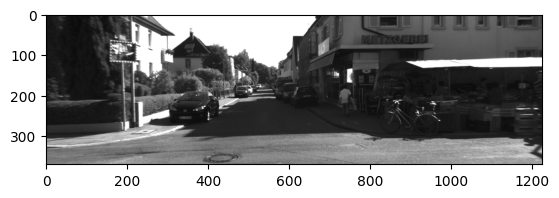

In [6]:
plt.imshow(img_r)

Left Image

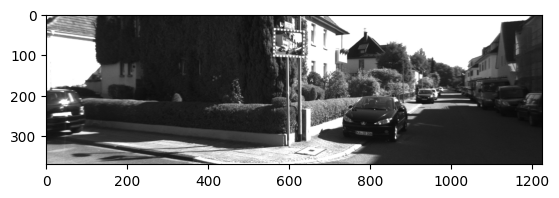

In [7]:
plt.imshow(img_l)

Using the sift operator for finding the keypoints

In [9]:
sift = cv2.SIFT_create()
gray_img_r = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
keypoints_r, descriptors_r = sift.detectAndCompute(gray_img_r, None)

(370, 1226, 3)


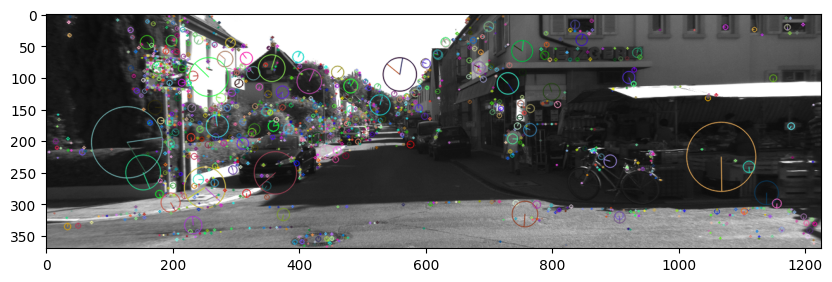

In [10]:
des_img_r = cv2.drawKeypoints(gray_img_r, keypoints_r, gray_img_r, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(des_img_r.shape)
plt.figure(figsize=(10,30))
plt.imshow(des_img_r)

SIFT operator and the corresponding keypoint

In [12]:
sift = cv2.SIFT_create()
gray_img_l = cv2.cvtColor(img_l, cv2.COLOR_BGR2GRAY)
keypoints_l, descriptors_l = sift.detectAndCompute(gray_img_l, None)


(370, 1226, 3)


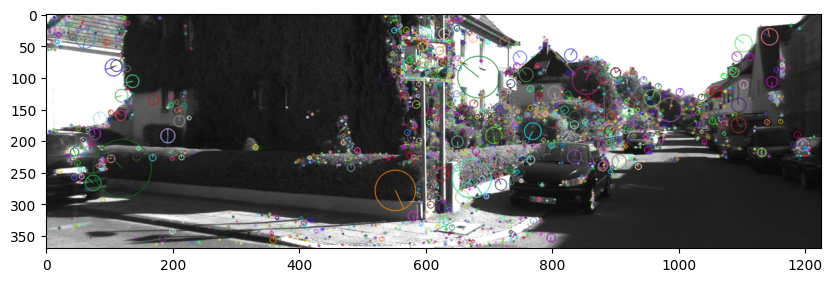

In [13]:
des_img_l = cv2.drawKeypoints(gray_img_l, keypoints_l, gray_img_l, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
print(des_img_l.shape)
plt.figure(figsize=(10,30))
plt.imshow(des_img_l)

Fundamental Matrix

In [14]:
F_M = np.array([[3.34638533e-07, 7.58547151e-06, -2.04147752e-03],
                                [-5.83765868e-06, 1.36498636e-06, 2.67566877e-04],
                                [1.45892349e-03, -4.37648316e-03, 1.00000000e+00]])

print(F_M)

[[ 3.34638533e-07  7.58547151e-06 -2.04147752e-03]
 [-5.83765868e-06  1.36498636e-06  2.67566877e-04]
 [ 1.45892349e-03 -4.37648316e-03  1.00000000e+00]]


Epipolar line equation

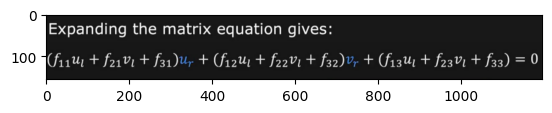

In [16]:
epipolar_eq = cv2.imread("./Epipolar_eq.png", cv2.IMREAD_COLOR)
plt.imshow(epipolar_eq)

Function for plotting epipolar lines

In [18]:
def plot_epipolar(keypoints, img, right = True):
    epi_points = keypoints
    epi_points = random.sample(keypoints, 15)
    fig = plt.figure(figsize = (30, 20))
    plt.imshow(img)
    for i in range(len(epi_points)):
        u_l , v_l = epi_points[i].pt
        x_val = np.linspace(0, 1226, 1226)
        x = []
        y = []
        for val in x_val:
            if(right):
                y_val = ((F_M[0][0]*u_l + F_M[1][0]*v_l + F_M[2][0])*val + (F_M[0][2]*u_l + F_M[1][2]*v_l + F_M[2][2])) / -(F_M[0][1]*u_l + F_M[1][1]*v_l + F_M[2][1])
            else:
                y_val = ((F_M[0][0]*u_l + F_M[0][1]*v_l + F_M[0][2])*val + (F_M[2][0]*u_l + F_M[2][1]*v_l + F_M[2][2])) / -(F_M[1][0]*u_l + F_M[1][1]*v_l + F_M[1][2])
            if(y_val > 0 and y_val < 360):
                x.append(val)
                y.append(y_val)
        y = np.array(y)
        plt.plot(x, y, linewidth=3)
    plt.show()

Plotting epipolar lines on right image

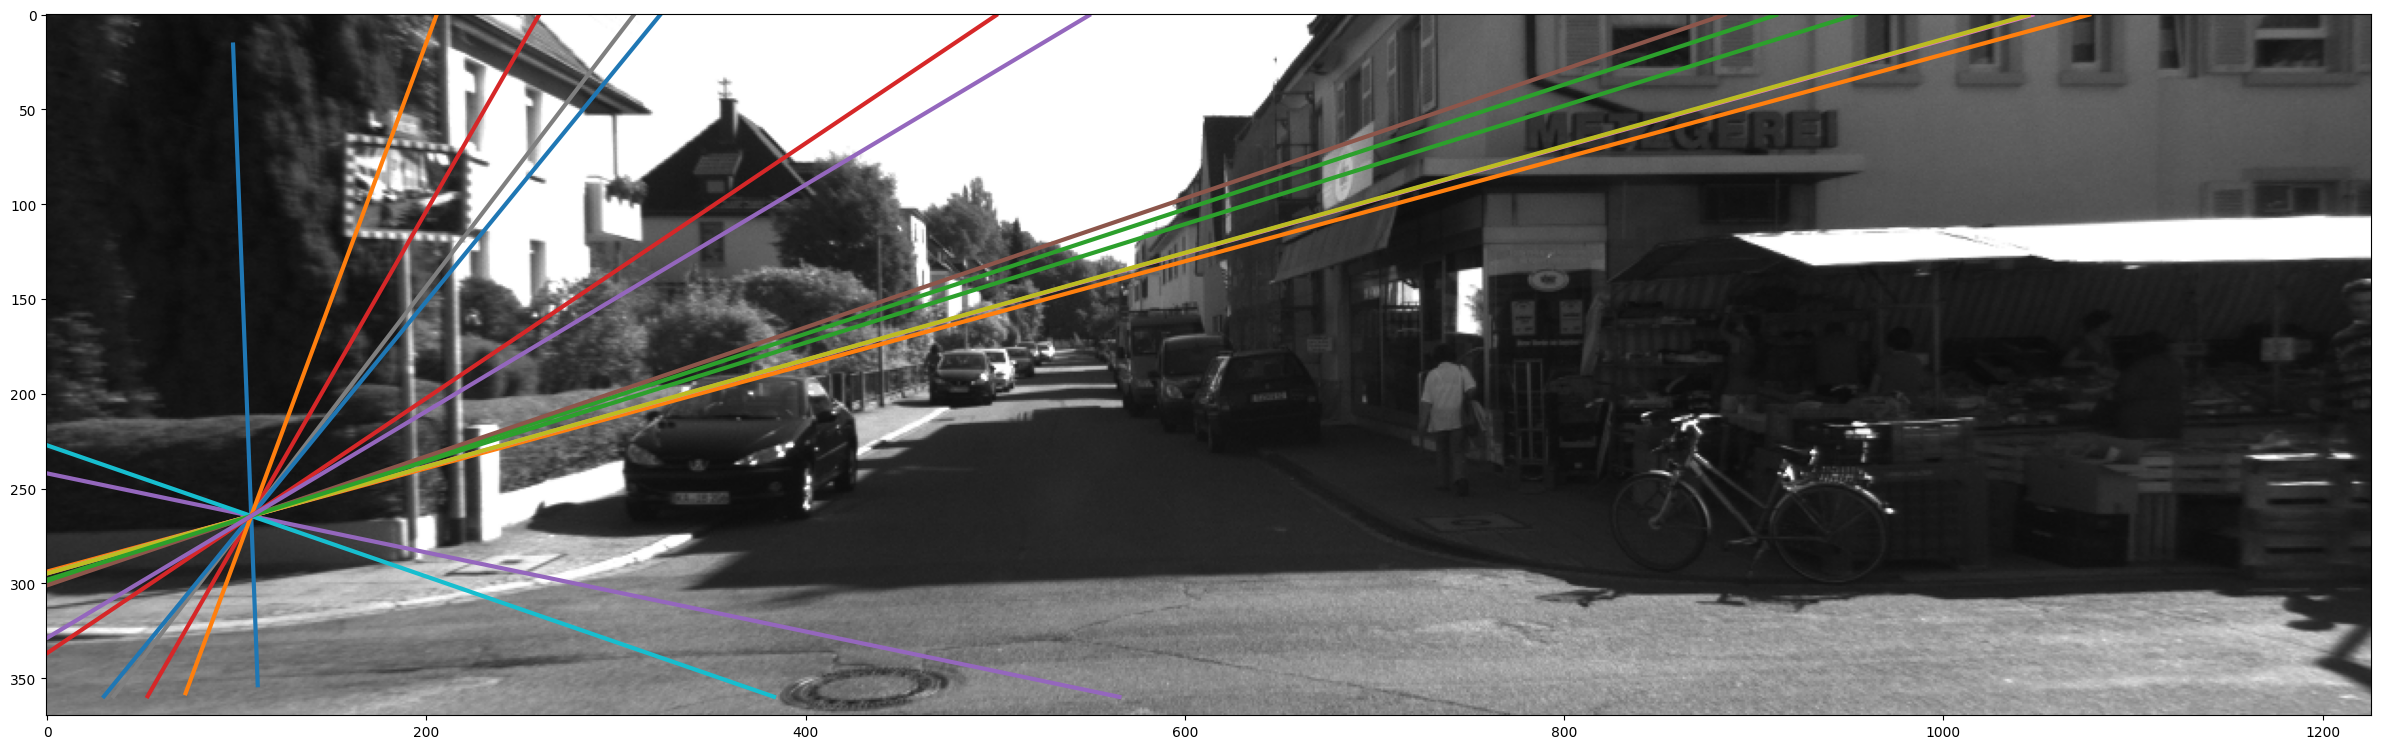

In [19]:
plot_epipolar(keypoints_l, img_r, right = True)

Epipolar on left image

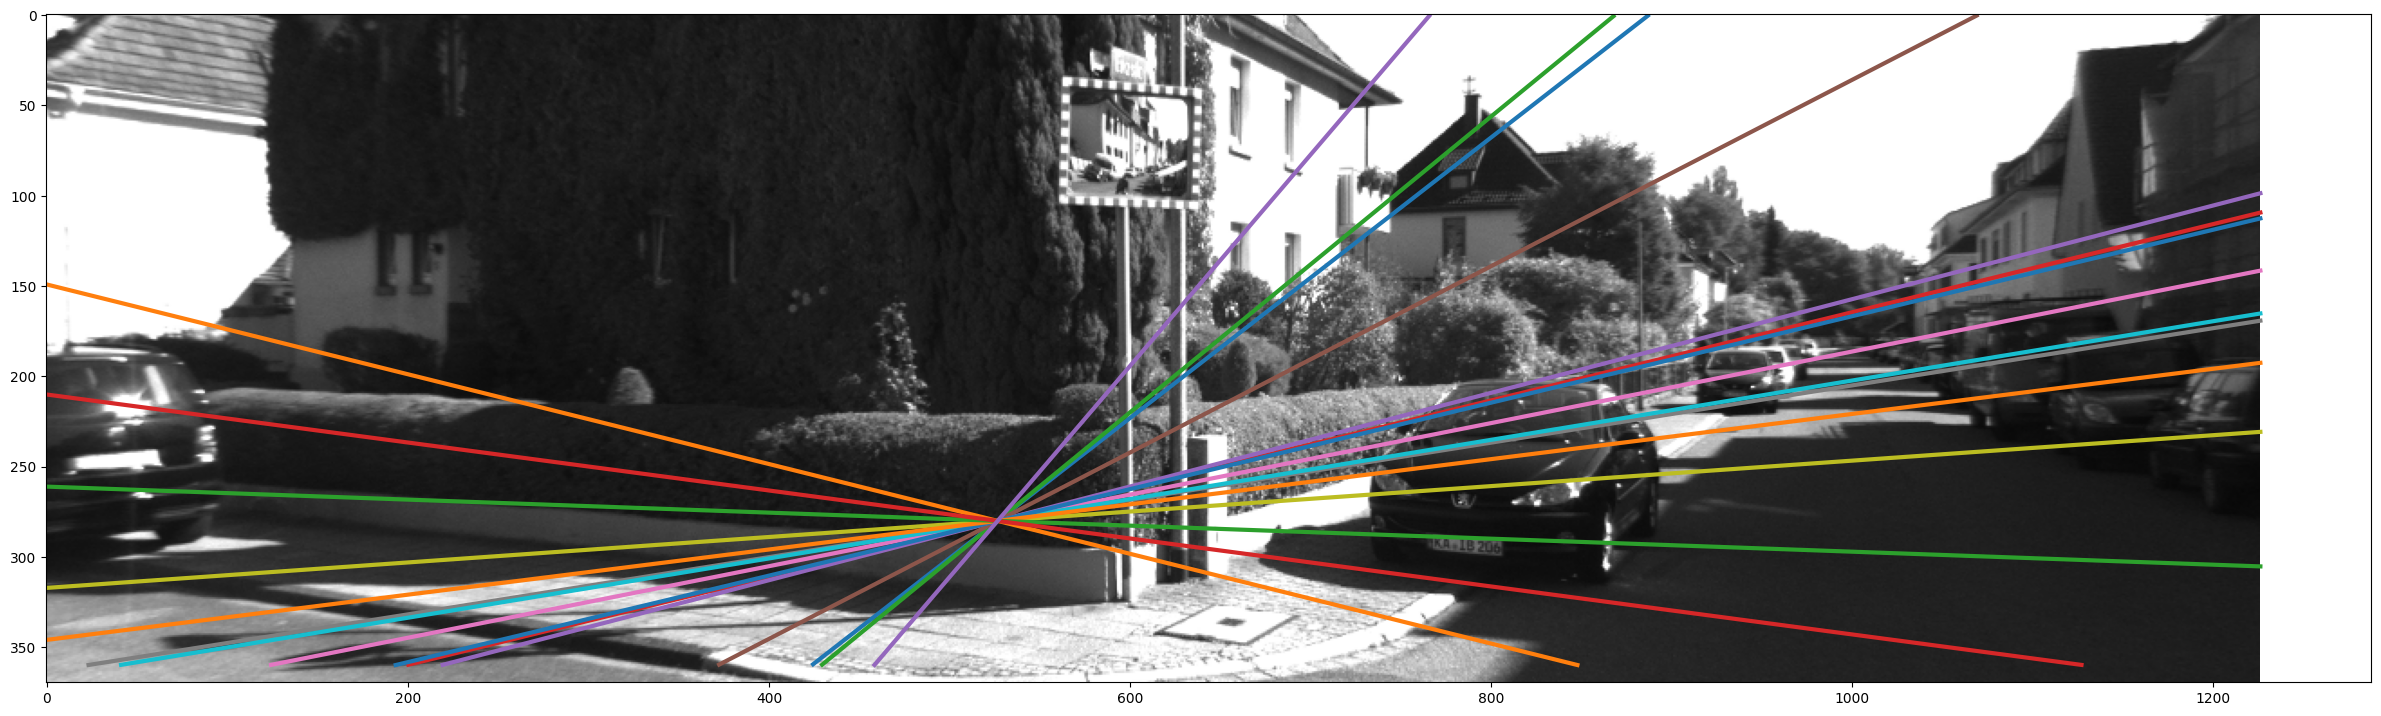

In [33]:
plot_epipolar(keypoints_r, img_l, right = False)

Function for finding the corresponding points

In [61]:
def find_corresponding_point(x1, y1, fundamental_matrix, inp_dim_x, inp_dim_y):
    # Compute the epipolar line in the second image
    epipolar_line = np.dot(np.array([x1,y1,1]).transpose(),fundamental_matrix)
    # search_range =   # Example range (pixels)
    best_matching_point = None
    best_matching_sad = float('inf')
    half_window = 3
    # Ensure that slice indices are integers
    x1, y1, half_window = int(x1), int(y1), int(half_window)
    # Extract the window from the first image (right_bike)
    window1 = gray_img_r[y1 - half_window:y1 + half_window + 1, x1 - half_window:x1 + half_window + 1]

    # Search for the corresponding point along the epipolar line in the second image using SAD and descriptor matching
    for x2 in range(x1-50, x1+50):
        y2 = int((-epipolar_line[0] * x2 - epipolar_line[2]) / epipolar_line[1])  # Compute y coordinate from the line equation
        # Check if (x2, y2) is within the image boundaries
        if 0 <= x2 < inp_dim_x and 0 <= y2 < inp_dim_y:
            # Extract the window from the second image (left_bike)
            window2 = gray_img_l[y2 - half_window:y2 + half_window + 1, x2 - half_window:x2 + half_window + 1]
            if window2.shape != window1.shape:
                continue  

            # Compute SAD (Sum of Absolute Differences) between the windows
            sad_value = np.sum(np.abs(window1.astype(np.float32) - window2.astype(np.float32)))
            # Update best matching point if the SAD value is smaller
            if sad_value < best_matching_sad:
                best_matching_sad = sad_value
                best_matching_point = (x2, y2)

    # Output the best matching point and its SAD value
    if(best_matching_point == None):
        return (-1,-1)
    return best_matching_point

Function for finding the epipoles of the images

In [54]:
def find_epipole(fundamental_matrix, of_left = True):
    p1 = np.array([200,200,1])
    p2 = np.array([300,300,1])
    L1 = None
    L2 = None
    if(of_left == False):
        L1 = np.dot(p1.transpose(), fundamental_matrix)
        L2 = np.dot(p2.transpose(), fundamental_matrix)
    else:
        L1 = np.dot(fundamental_matrix, p1)
        L2 = np.dot(fundamental_matrix, p2) 
    
    y = (L2[2]/L2[0] - L1[2]/L1[0]) / (L1[1]/L1[0] - L2[1]/L2[0])
    return y

Sampling the 10 points on left image and plotting the corresponding epipolar point in the right image

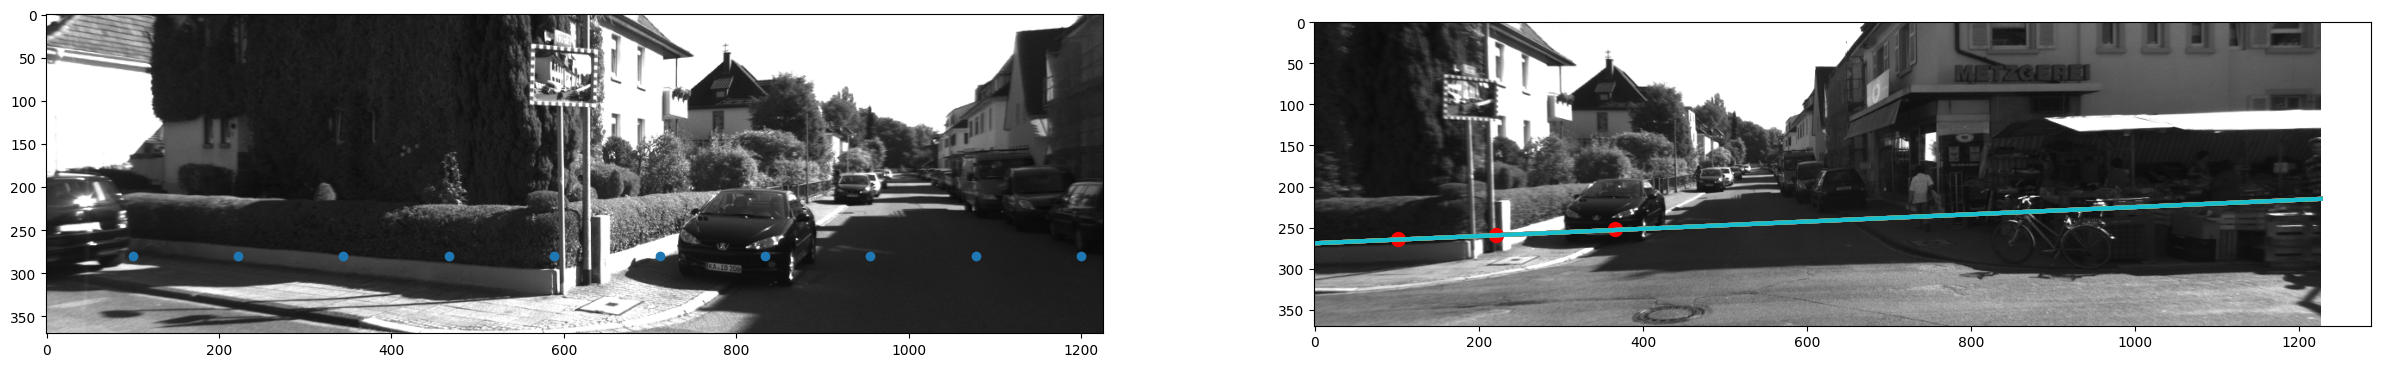

<Figure size 1500x1000 with 0 Axes>

In [56]:
x_epipolar_point = np.linspace(100,1200,10)
left_y_epipole = find_epipole(F_M, True)
y_epipolar_point = left_y_epipole*np.ones_like(x_epipolar_point)

fig, axs = plt.subplots(1,2,figsize = (30, 20))
axs[0].imshow(img_l)
axs[0].scatter(x_epipolar_point, y_epipolar_point)

corres_point_x = []
corres_point_y = []

for i in range(10):
    x_cor, y_cor = find_corresponding_point(x_epipolar_point[i], y_epipolar_point[i], F_M, img_r.shape[0], img_r.shape[1])
    if(y_cor>50 and x_cor>50):
        corres_point_x.append(x_cor)
        corres_point_y.append(y_cor)
axs[1].scatter(corres_point_x, corres_point_y, color = "red", s=100)

fig = plt.figure(figsize = (15, 10))
for i in range(10):
    axs[1].imshow(img_r)
    u_l = x_epipolar_point[i]
    # u_l = random.randint(10,1000)
    v_l = y_epipolar_point[i]
    # v_l = random.randint(500,1000)
    x_val = np.linspace(0, 1226, 1226)
    x = []
    y = [] 
    p1 = np.array([u_l, v_l, 1])
    # Compute the epipolar line in the second image
    epipolar_line = np.dot(p1, F_M)
    for val in x_val:
        y_val = ((epipolar_line[0])*val + (epipolar_line[2])) / -(epipolar_line[1])
        if(y_val > 0 and y_val < 360):
            x.append(val)
            y.append(y_val)
            # axs[1].scatter(val, y_val, color='red')
            # axs.scatter()
    axs[1].plot(x, y, linewidth=3)

Sampling 10 equidistant points from right image and plotting the epipolar lines

264.38074313566176


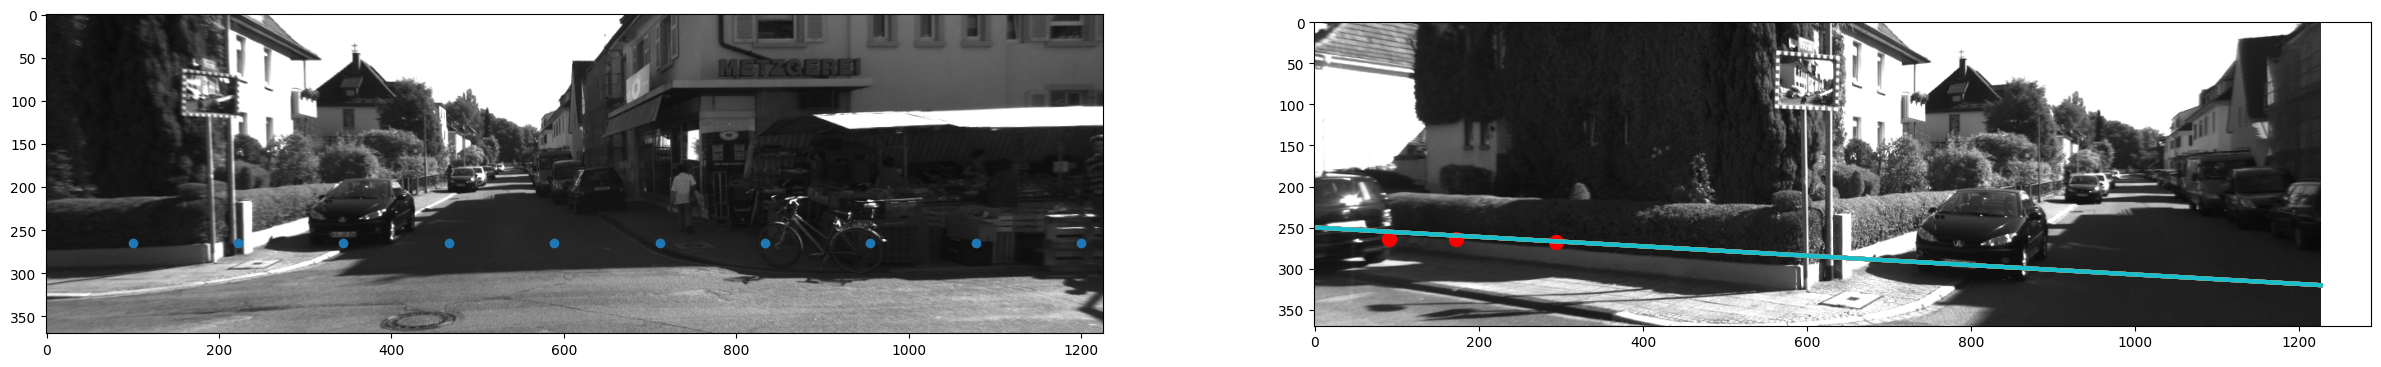

<Figure size 1500x1000 with 0 Axes>

In [64]:
x_epipolar_point_r = np.linspace(100,1200,10)
right_y_epipole = find_epipole(F_M, False)
y_epipolar_point_r = right_y_epipole*np.ones_like(x_epipolar_point_r)

fig, axs = plt.subplots(1,2, figsize = (30, 20))
axs[0].imshow(img_r)
axs[0].scatter(x_epipolar_point_r, y_epipolar_point_r)
print(right_y_epipole)

corres_point_x = []
corres_point_y = []

for i in range(10):
    x_cor, y_cor = find_corresponding_point(x_epipolar_point_r[i], y_epipolar_point_r[i], F_M, img_r.shape[0], img_r.shape[1])
    if(y_cor>0 and x_cor>0):
        corres_point_x.append(x_cor)
        corres_point_y.append(y_cor)

axs[1].scatter(corres_point_x, corres_point_y, color = "red", s=100)

fig = plt.figure(figsize = (15, 10))
for i in range(10):
    axs[1].imshow(img_l)
    u_l = x_epipolar_point_r[i]
    # u_l = random.randint(10,1000)
    v_l = y_epipolar_point_r[i]
    # v_l = random.randint(500,1000)
    x_val = np.linspace(0, 1226, 1226)
    x = []
    y = []
    p1 = np.array([[u_l], [v_l], [1]])
    # Compute the epipolar line in the second image
    epipolar_line = np.dot(F_M, p1)
    # print(epipolar_line[0],epipolar_line[1], epipolar_line[2])
    for val in x_val:
        y_val = ((epipolar_line[0])*val + (epipolar_line[2])) / -(epipolar_line[1])
        if(y_val > 0 and y_val < 360):
            x.append(val)
            y.append(y_val)
    axs[1].plot(x, y, linewidth=3)